# Лабораторная 6. Графовые нейронные сети

**Выполнила Быковченко Софья, группа P4155**

**Задание:**

Написать графовые нейронную сеть для расчета ширины запрещенной зоны для двумерных дихалькогенидов переходных металлов

Описание задачи и набор данных - https://github.com/HSE-LAMBDA/IDAO-2022. Там же есть baseline (его не использовать).

Выбор архитектура и комбинации слоев на Ваше усмотрение.

In [1]:
import json
import pandas as pd
from pathlib import Path
from pymatgen.core import Structure
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

Перед тем как перейти к построению графовой нейронной сети, необходимо определить базовые компоненты, без которых невозможен процесс обучения: нелинейное преобразование и функция ошибки.

## Вспомогательныые функции

В архитектуре любой нейросети ключевую роль играет нелинейная функция активации. Без неё даже многослойная сеть сводится к линейному преобразованию. Используем ReLU:

In [2]:
def relu(x):
    return np.maximum(0, x)

Она проста в вычислении и хорошо зарекомендовала себя на практике, особенно в задачах, где важна разреженность активаций. Для реализации обратного распространения ошибки (backpropagation) также требуется производная этой функции:

In [3]:
def relu_grad(x):
    return (x > 0).astype(np.float32)

Градиент равен единице, когда вход положителен, и нулю - в противном случае. Такая форма позволяет эффективно передавать ошибку «назад» по сети без затухания.

Поскольку задача состоит в предсказании непрерывной величины - ширины запрещённой зоны (в электронвольтах), необходимо выбрать подходящую функцию потерь для задачи регрессии.

Классический выбор (среднеквадратичная ошибка (MSE)) чувствителен к выбросам: один сильно ошибочный пример может доминировать в градиенте. В то же время средняя абсолютная ошибка (MAE) менее чувствительна к шуму, но имеет постоянный градиент, из-за чего обучение вблизи минимума замедляется.

Чтобы совместить преимущества обоих подходов, используется Huber Loss - гибридная функция, которая ведёт себя как MSE вблизи нуля и как MAE при больших отклонениях:

In [4]:
def huber_loss(pred, target, delta=1.0):
    err = pred - target
    if abs(err) <= delta:
        return 0.5 * err ** 2
    else:
        return delta * (abs(err) - 0.5 * delta)

Параметр delta = 0.5 выбран с учётом масштаба целевой переменной. Ширина запрещённой зоны в дихалькогенидах как правило лежит в диапазоне от 0.5 до 2.5 эВ, поэтому отклонения менее 0.5 эВ считаются умеренными и штрафуются квадратично.

Соответствующий градиент:

In [5]:
def huber_grad(pred, target, delta=1.0):
    err = pred - target
    if abs(err) <= delta:
        return err
    else:
        return delta * np.sign(err)

## Архитектура модели. GraphSAGE

Графовая нейронная сеть решает задачу отображения  

где G = (V, E) - исходный граф (в нашем случае кристаллическая структура), а T - множество пар (n_i, t_i), где t_i - целевая переменная, связанная с графом в целом (ширина запрещённой зоны).

Согласно обобщённой схеме GNN, каждая вершина v_n обновляет своё внутреннее состояние x_n на основе:
- собственного представления
- признаков рёбер e(v_n, v_{n-1})
- состояний соседей x_n(N(v_n))

Этот процесс описывается композицией двух функций:
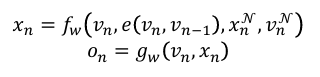
где f_w - функция обновления состояния вершины (реализуется через стек GNN-слоёв), а g_w - readout-функция, агрегирующая локальные представления в глобальное представление графа. Именно эта структура лежит в основе реализованной модели.

Среди рассмотренных в лекции архитектур GCN, GAT, GIN, GraphSAGE я остановились на **Graph Sample and Aggregate (GraphSAGE)**. Эта архитектура хорошо подходит для задачи предсказания свойств материалов по следующим причинам:

1. В отличие от GCN, GraphSAGE обучает параметризованную функцию агрегации, а не просто распространяет сигнал по фиксированному графу. Это позволяет применять модель к новым, ранее не виденным структурам

2. 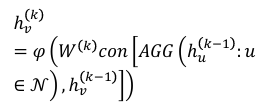
   функция AGG может быть любой дифференцируемой операцией - средним, максимумом, суммой, LSTM и др. Я использую взвешенное среднее (через нормализованную матрицу смежности), что соответствует физической интерпретации: вклад ближайших атомов в локальное окружение больше.

3. Не требует хранения полной матрицы D^{-0.5}AD^{-0.5}, а работает с локальной агрегацией, что упрощает реализацию на больших графах

In [6]:
class MyGraphSAGE:
    """
    Графовая нейронная сеть на основе GraphSAGE для предсказания ширины запрещённой зоны в двумерных дихалькогенидах переходных металлов
    
    Архитектура:
      1. Несколько слоёв GraphSAGE с агрегацией по среднему
      2. Skip-connections для стабилизации градиентов
      3. LayerNorm и Dropout для регуляризации
      4. Readout-функция: конкатенация mean и max pooling
      5. MLP-голова для регрессии конечного значения
    """
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], lr=2e-3, dropout=0.2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.lr = lr
        self.dropout = dropout
        self.params = {}
        self.grads = {}
        self.cache = {}
        self._init_params()
        
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.best_params = None

    def _init_params(self):
        dims = [self.input_dim] + self.hidden_dims
        
        # GraphSAGE слои
        for i in range(len(dims)-1):
            in_dim = dims[i]
            out_dim = dims[i+1]
            
            # веса для преобразования конкатенации [h_v || AGG(h_N(v))]
            limit = np.sqrt(6 / (2*in_dim + out_dim))
            self.params[f"W_sage_{i}"] = np.random.uniform(-limit, limit, (2*in_dim, out_dim))
            self.params[f"b_sage_{i}"] = np.zeros(out_dim)
            
            # skip connection добавляет h_v^{(k-1)} напрямую к выходу слоя
            limit_skip = np.sqrt(6 / (in_dim + out_dim))
            self.params[f"W_skip_{i}"] = np.random.uniform(-limit_skip, limit_skip, (in_dim, out_dim))

        # MLP-голова для регрессии
        # после readout получаем вектор фиксированной длины
        last_hidden_dim = self.hidden_dims[-1]
        graph_emb_dim = 2 * last_hidden_dim  # mean + max pooling
        
        mlp_dims = [graph_emb_dim, 64, 32, 1]
        
        for i in range(len(mlp_dims)-1):
            in_dim = mlp_dims[i]
            out_dim = mlp_dims[i+1]
            limit = np.sqrt(6 / (in_dim + out_dim))
            self.params[f"W_mlp_{i}"] = np.random.uniform(-limit, limit, (in_dim, out_dim))
            self.params[f"b_mlp_{i}"] = np.zeros(out_dim)
        
        print(f"MLP dimensions: {mlp_dims}")
        print(f"Graph embedding dim: {graph_emb_dim}")

    def forward(self, X, A, training=True):
        """
        Прямой проход по графу.
        X: [N, D] — матрица признаков вершин
        A: [N, N] — бинарная матрица смежности
        """
        self.cache = {}
        H = X
        N = H.shape[0]
        
        # добавляем петли к матрице смежности A <- A + I, чтобы вершина учитывала саму себя
        A_self = A + np.eye(N)
        deg = np.sum(A_self, axis=1, keepdims=True) + 1e-8
        A_norm = A_self / deg
        
        self.cache["A_norm"] = A_norm

        # GraphSAGE слои
        for i in range(len(self.hidden_dims)):
            self.cache[f"H_prev_{i}"] = H.copy()
            
            # Агрегация соседей AGG = среднее (взвешенное по степеням)
            H_neigh = A_norm @ H
            
            # Конкатенация собственных признаков и признаков соседей [h_v || AGG(h_N(v))]
            H_concat = np.concatenate([H, H_neigh], axis=1)
            
            # Линейное преобразование + skip-connection
            Z = H_concat @ self.params[f"W_sage_{i}"] + self.params[f"b_sage_{i}"]
            Z += H @ self.params[f"W_skip_{i}"]
            
            # ReLU активация
            H = relu(Z)
            
            # LayerNorm
            mu = H.mean(axis=1, keepdims=True)
            sigma = H.std(axis=1, keepdims=True) + 1e-8
            H = (H - mu) / sigma
            
            # Dropout (только при обучении)
            if training and self.dropout > 0:
                mask = np.random.binomial(1, 1-self.dropout, size=H.shape) / (1-self.dropout)
                H = H * mask
                self.cache[f"dropout_mask_{i}"] = mask
            
            self.cache[f"Z_{i}"] = Z
            self.cache[f"H_concat_{i}"] = H_concat
            self.cache[f"mu_{i}"] = mu
            self.cache[f"sigma_{i}"] = sigma

        # Readout: преобразование графа -> вектор
        H_mean = np.mean(H, axis=0, keepdims=True)  # (1, last_hidden_dim)
        H_max = np.max(H, axis=0, keepdims=True)    # (1, last_hidden_dim)
        graph_emb = np.concatenate([H_mean, H_max], axis=1)  # (1, 2*last_hidden_dim)
        
        self.cache["graph_emb"] = graph_emb
        self.cache["num_nodes"] = N
        self.cache["training"] = training
        self.cache["H_mean"] = H_mean
        self.cache["H_max"] = H_max
        self.cache["H_last"] = H 

        # MLP head регрессия ширины зоны
        current = graph_emb
        for i in range(3):  # 3 слоя MLP: 2 скрытых + выходной
            Z_mlp = current @ self.params[f"W_mlp_{i}"] + self.params[f"b_mlp_{i}"]
            
            if i < 2:  # скрытые слои с активацией и dropout
                current = relu(Z_mlp)
                if training and self.dropout > 0:
                    mask_mlp = np.random.binomial(1, 1-self.dropout, size=current.shape) / (1-self.dropout)
                    current = current * mask_mlp
                    self.cache[f"dropout_mlp_{i}"] = mask_mlp
            else:  # выходной слой (линейный)
                current = Z_mlp
            
            self.cache[f"Z_mlp_{i}"] = Z_mlp
        
        return current.item()

    def backward(self, dL):
        self.grads = {}
        d_out = np.array([[dL]])
        
        # градиенты через MLP head
        for i in reversed(range(3)):
            if i == 2:  # выходной слой
                dZ_mlp = d_out
            else:  # скрытые слои
                dZ_mlp = d_out * relu_grad(self.cache[f"Z_mlp_{i}"])
                if self.cache["training"] and f"dropout_mlp_{i}" in self.cache:
                    dZ_mlp *= self.cache[f"dropout_mlp_{i}"]
            
            # определяем вход для текущего слоя
            if i == 0:
                input_mlp = self.cache["graph_emb"]
            else:
                input_mlp = relu(self.cache[f"Z_mlp_{i-1}"])
                if self.cache["training"] and f"dropout_mlp_{i-1}" in self.cache:
                    input_mlp *= self.cache[f"dropout_mlp_{i-1}"]
            
            self.grads[f"W_mlp_{i}"] = input_mlp.T @ dZ_mlp
            self.grads[f"b_mlp_{i}"] = dZ_mlp.sum(axis=0)
            
            if i > 0:
                d_out = dZ_mlp @ self.params[f"W_mlp_{i}"].T
        
        # градиент к graph embedding
        d_graph_emb = d_out
        
        # разделяем градиент на mean и max части
        last_hidden_dim = self.hidden_dims[-1]
        d_mean = d_graph_emb[:, :last_hidden_dim]
        d_max = d_graph_emb[:, last_hidden_dim:]
        
        # распространяем на узлы для mean pooling
        N = self.cache["num_nodes"]
        dH_mean = np.repeat(d_mean / N, N, axis=0)
        
        # градиент для max pooling
        H_last = self.cache["H_last"]
        max_indices = np.argmax(H_last, axis=0)
        
        dH_max = np.zeros((N, last_hidden_dim))
        for j in range(last_hidden_dim):
            dH_max[max_indices[j], j] = d_max[0, j]
        
        dH = dH_mean + dH_max
        
        A_norm = self.cache["A_norm"]
        
        # градиенты через GraphSAGE слои
        for i in reversed(range(len(self.hidden_dims))):
            # применяем dropout mask
            if self.cache["training"] and f"dropout_mask_{i}" in self.cache:
                dH *= self.cache[f"dropout_mask_{i}"]
            
            # градиент через LayerNorm
            mu = self.cache[f"mu_{i}"]
            sigma = self.cache[f"sigma_{i}"]
            
            # градиент после нормализации
            dH_norm = dH / sigma
            
            # градиент через ReLU
            dZ = dH_norm * relu_grad(self.cache[f"Z_{i}"])
            
            # градиенты для GraphSAGE слоя
            H_concat = self.cache[f"H_concat_{i}"]
            self.grads[f"W_sage_{i}"] = H_concat.T @ dZ
            self.grads[f"b_sage_{i}"] = dZ.sum(axis=0)
            
            # градиент для skip connection
            H_prev = self.cache[f"H_prev_{i}"]
            self.grads[f"W_skip_{i}"] = H_prev.T @ dZ
            
            # распространяем градиент дальше
            W = self.params[f"W_sage_{i}"]
            dH_concat = dZ @ W.T
            
            in_dim = dH_concat.shape[1] // 2
            dH_self = dH_concat[:, :in_dim]
            dH_neigh = dH_concat[:, in_dim:]
            
            # добавляем градиент от skip connection
            dH_self += dZ @ self.params[f"W_skip_{i}"].T
            
            # обновляем dH для следующего слоя
            dH = dH_self + A_norm.T @ dH_neigh

    def step(self, epoch):
        if epoch > 0:
            if self.lr > 1e-4 and epoch % 25 == 0:
                self.lr = max(self.lr * 0.85, 1e-4)
            elif self.lr <= 1e-4 and epoch % 40 == 0:
                self.lr = max(self.lr * 0.9, 1e-5)
        
        for k in self.params:
            if k in self.grads:
                grad_clipped = np.clip(self.grads[k], -2.0, 2.0)
                self.params[k] -= self.lr * grad_clipped

    def update_best(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_params = {k: v.copy() for k, v in self.params.items()}
            return True
        return False


Класс реализует следующую последовательность операций:

##### Обновление состояний вершин
На каждом слое:
- К матрице смежности A добавляются петли (A <- A + I), чтобы вершина учитывала саму себя
- Производится нормализация по степеням D^{-1}A, что эквивалентно взятию среднего по окрестности
- Для каждой вершины формируется вектор (усреднённое представление соседей)
- Этот вектор линейно преобразуется, к нему добавляется skip-connection, затем применяется ReLU и LayerNorm для стабилизации обучения.

Skip-connections, хотя и не упоминаются напрямую в лекции, являются стандартным приёмом для глубоких сетей и помогают избежать затухания градиентов при обучении трёхслойной GNN.

##### Readout-функция
После обработки всех слоёв необходимо получить единый вектор представления графа. Для этого используется функция g_w, инвариантная к перестановке вершин. Я применяю гибридную стратегию.

Представление всего графа (эмбеддинг графа) формируется путём конкатенации (объединения) двух векторов:
— первого, полученного как среднее арифметическое всех эмбеддингов вершин,
— и второго, полученного как покомпонентный максимум всех эмбеддингов вершин.

Такой подход объединяет устойчивость среднего к выбросам и чувствительность максимума к экстремальным локальным особенностям (например дефектам в решётке).

##### Регрессия ширины зоны
Финальный вектор h_G подаётся в многослойный перцептрон (MLP), завершающийся линейным слоем. Нелинейные слои MLP позволяют модели улавливать сложные, нелинейные зависимости между структурой кристалла и его электронными свойствами.

## Обработка данных

Одной из ключевых особенностей задачи предсказания свойств материалов является необходимость корректного представления кристаллической структуры в виде графа. 

Для каждой вершины (атома) построим расширенный вектор признаков, включающий:

- Фундаментальные атомные свойства. Атомный номер и атомная масса (нормированные для масштабной согласованности)
- Геометрическое положение. Как декартовы, так и дробные координаты. Первые несут информацию о реальном расположении атома в пространстве, вторые инвариантны к размеру элементарной ячейки.
- One-hot кодирование элемента. Учитывая, что в датасете присутствуют только четыре типа атомов (Mo, W, S, Se), это позволяет модели точно различать химическую природу узлов
- Физико-химические характеристики. Электроотрицательность, ковалентный радиус и валентность - параметры, напрямую влияющие на электронную структуру и, следовательно, на ширину запрещённой зоны
- Категориальные признаки. Признаки «переходный металл / халькоген», которые вводят дополнительную физическую семантику

Подход был подсмотрен из baseline-решения, где также используются физически значимые признаки атомов, но реализован полностью самостоятельно. Не применяется готовый `CrystalGraph` из MEGNet, а формируются признаки вручную, опираясь на документацию `pymatgen`.

In [7]:
def improved_atom_features(site):
    symbol = site.specie.symbol
    
    features = []
    
    features.append(site.specie.Z / 100.0)
    features.append(site.specie.atomic_mass / 300.0)
    features.extend(site.coords / 10.0)
    features.extend(site.frac_coords)
    
    elements = ["Mo", "W", "S", "Se"]
    for e in elements:
        features.append(1.0 if symbol == e else 0.0)
    
    # шкала Полинга, электрроотрицательность
    en_dict = {"Mo": 2.16, "W": 2.36, "S": 2.58, "Se": 2.55}
    features.append(en_dict.get(symbol, 2.0) / 4.0)
    # ковалентный радиус
    cr_dict = {"Mo": 1.54, "W": 1.62, "S": 1.05, "Se": 1.20}
    features.append(cr_dict.get(symbol, 1.0) / 2.0)
    # валентность
    valence_dict = {"Mo": 6, "W": 6, "S": 6, "Se": 6}
    features.append(valence_dict.get(symbol, 4) / 10.0)
    
    features.append(1.0 if symbol in ["Mo", "W"] else 0.0)
    features.append(1.0 if symbol in ["S", "Se"] else 0.0)
    
    return np.array(features, dtype=np.float32)

Граф строится следующим образом:
- Вершины - атомы кристаллической решётки
- Рёбра создаются между парами атомов, расстояние между которыми меньше заданного порога `cutoff = 3.2 Å`.

Это значение выбрано на основе межатомных расстояний в дихалькогенидах. Например, связь Mo–S составляет ~2.4 Å, а S–S в слое — около 3.2 Å. Порог чуть выше, чем максимальное внутрислойное расстояние, позволяет захватить всю топологию 2D-слоя, но не включает межслойные взаимодействия.

Матрица смежности `A` остаётся бинарной, что упрощает вычисления и вполне достаточно для данной задачи, поскольку веса связей косвенно учитываются при агрегации через степень вершин.

In [8]:
def structure_to_graph_improved(structure, cutoff=3.2):
    coords = np.array([site.coords for site in structure])
    
    X = np.vstack([improved_atom_features(site) for site in structure])
    
    dist = cdist(coords, coords)
    A = (dist < cutoff).astype(np.float32)
    np.fill_diagonal(A, 0)
    
    return X, A

## Загрузка и предобработка данных

Для обучения модели используется официальный датасет соревнования IDAO-2022, содержащий 2966 кристаллических структур в формате JSON и соответствующие им значения ширины запрещённой зоны в файле targets.csv.

Каждая структура загружается с помощью библиотеки pymatgen, после чего преобразуется в граф с помощью функции structure_to_graph_improved, описанной ранее.
- Проверяется наличие структуры в целевом файле (во избежание пропущенных значений)
- Для каждой структуры сохраняются: матрица признаков вершин X, матрица смежности A, целевое значение y и идентификатор.

В результате формируется единый список graphs, где каждый элемент представляет собой готовый к обучению граф.

In [9]:
data_path = Path("data_public/dichalcogenides_public")
targets = pd.read_csv(data_path / "targets.csv", index_col=0)
structures_path = data_path / "structures"

graphs = []
print("Обработка структур...")

for i, file in enumerate(structures_path.iterdir()):
    sid = file.stem
    if sid not in targets.index:
        continue
    try:
        with open(file) as f:
            d = json.load(f)
        structure = Structure.from_dict(d)
        y = targets.loc[sid].values[0]
        X, A = structure_to_graph_improved(structure)
        graphs.append((X, A, y, sid))
        if len(graphs) % 500 == 0:
            print(f"- Обработано {len(graphs)} структур")
    except Exception:
        continue

print(f"\nВсего загружено {len(graphs)} графов")

Обработка структур...
- Обработано 500 структур
- Обработано 1000 структур
- Обработано 1500 структур
- Обработано 2000 структур
- Обработано 2500 структур

Всего загружено 2966 графов


## Разделение и нормализация

Перед началом обучения необходимо правильно организовать данные и привести их к однородному масштабу

Датасет был разделён на три части:
- Обучающая выборка (2400 структур) - используется для обновления весов модели
- Валидационная выборка (300 структур) - служит для контроля переобучения и ранней остановки
- Тестовая выборка (266 структур) - применяется только один раз в самом конце для оценки качества

In [10]:
np.random.shuffle(graphs)
train_data = graphs[:2400]
val_data = graphs[2400:2700]
test_data = graphs[2700:]

In [11]:
print("Разделение данных")
print(f"- Тренировочных: {len(train_data)}")
print(f"- Валидационных: {len(val_data)}")
print(f"- Тестовых: {len(test_data)}")

Разделение данных
- Тренировочных: 2400
- Валидационных: 300
- Тестовых: 266


Целевая переменная (ширина запрещённой зоны) распределена в диапазоне от ~0.4 до ~2.5 эВ. Прямое обучение на таких значениях может замедлить сходимость из-за несбалансированного масштаба градиентов. Поэтому применяем z-нормализацию

In [12]:
y_train = np.array([g[2] for g in train_data])
mean, std = y_train.mean(), y_train.std() + 1e-8

In [13]:
print("Статистика таргета")
print(f"- Среднее: {mean:.4f} eV")
print(f"- STD: {std:.4f} eV")
print(f"- Min: {y_train.min():.4f} eV")
print(f"- Max: {y_train.max():.4f} eV")

Статистика таргета
- Среднее: 0.8288 eV
- STD: 0.5048 eV
- Min: 0.1244 eV
- Max: 1.8106 eV


In [14]:
norm = lambda y: (y - mean) / std
denorm = lambda y: y * std + mean

Аналогичная процедура применена и к признакам атомов. Векторы признаков содержат компоненты разного порядк. Такой разнородный масштаб может привести к доминированию одних признаков над другими.

In [15]:
print("Нормализация признаков...")
X_all = np.vstack([X for X, _, _, _ in train_data])
X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0) + 1e-8

Нормализация признаков...


In [16]:
def normalize_batch(data):
    normalized = []
    for X, A, y, sid in data:
        X_norm = (X - X_mean) / X_std
        normalized.append((X_norm, A, y, sid))
    return normalized

In [17]:
train_data_norm = normalize_batch(train_data)
val_data_norm = normalize_batch(val_data)
test_data_norm = normalize_batch(test_data)

In [18]:
X_sample, _, _, _ = train_data_norm[0]
input_dim = X_sample.shape[1]
print(f"Размерность признаков: {input_dim}")

Размерность признаков: 17


## Обучение модели

Модель обучается по схеме **ℎ<sub>S</sub>: G → T**, где из графа кристаллической структуры G = (V, E) предсказывается скалярная целевая переменная.

На каждой эпохе последовательно применяются функции обновления состояний вершин f_w (реализованные через стек GraphSAGE-слоёв) и readout-функция g_w (MLP над агрегированным эмбеддингом графа).

Обучение включает:
- Минимизацию Huber Loss - робастной функции потерь для регрессии
- Раннюю остановку по валидационной ошибке (в эВ), что предотвращает переобучение
- Сохранение лучших весов, обеспечивающее использование модели с оптимальной обобщающей способностью


In [19]:
model = MyGraphSAGE(input_dim=input_dim, hidden_dims=[128, 64, 32], lr=1e-3, dropout=0.2)

MLP dimensions: [64, 64, 32, 1]
Graph embedding dim: 64


In [20]:
print("Архитектура модели:")
print(f"- Входной слой: {input_dim}")
print(f"- GraphSAGE слои: {model.hidden_dims}")
print(f"- Learning rate: {model.lr}")
print(f"- Dropout: {model.dropout}")

Архитектура модели:
- Входной слой: 17
- GraphSAGE слои: [128, 64, 32]
- Learning rate: 0.001
- Dropout: 0.2


In [21]:
patience = 30
patience_counter = 0
best_epoch = 0
model.train_losses = []
model.val_losses = []
model.best_val_loss = float('inf')
model.best_params = None

In [22]:
print("\nЭпоха | Train Loss | Val MSE   | LR       | Status")
print("-" * 70)

for epoch in range(100):
    total_loss = 0
    np.random.shuffle(train_data_norm)
    
    for X, A, y, _ in train_data_norm:
        y_n = norm(y)
        pred = model.forward(X, A, training=True)
        loss = huber_loss(pred, y_n, delta=0.5)
        grad = huber_grad(pred, y_n, delta=0.5)
        model.backward(grad)
        model.step(epoch)
        total_loss += loss
    
    avg_train_loss = total_loss / len(train_data_norm)
    model.train_losses.append(avg_train_loss)
    
    val_loss = 0
    for X, A, y, _ in val_data_norm:
        pred = denorm(model.forward(X, A, training=False))
        val_loss += (pred - y) ** 2
    avg_val_loss = val_loss / len(val_data_norm)
    model.val_losses.append(avg_val_loss)
    
    improved = model.update_best(avg_val_loss)
    status = "УЛУЧШЕНИЕ" if improved else "Нет улучшения"
    
    if improved:
        best_epoch = epoch + 1
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0 or epoch < 10:
        print(f"{epoch+1:5d} | {avg_train_loss:10.6f} | {avg_val_loss:9.6f} | {model.lr:8.6f} | {status}")
    
    if patience_counter >= patience:
        print(f"\nРанняя остановка на эпохе {epoch+1}")
        break


Эпоха | Train Loss | Val MSE   | LR       | Status
----------------------------------------------------------------------
    1 |   0.322484 |  0.126341 | 0.001000 | УЛУЧШЕНИЕ
    2 |   0.179270 |  0.115029 | 0.001000 | УЛУЧШЕНИЕ
    3 |   0.143744 |  0.096203 | 0.001000 | УЛУЧШЕНИЕ
    4 |   0.127150 |  0.092362 | 0.001000 | УЛУЧШЕНИЕ
    5 |   0.122169 |  0.078636 | 0.001000 | УЛУЧШЕНИЕ
    6 |   0.113840 |  0.065906 | 0.001000 | УЛУЧШЕНИЕ
    7 |   0.107577 |  0.071473 | 0.001000 | Нет улучшения
    8 |   0.105337 |  0.059827 | 0.001000 | УЛУЧШЕНИЕ
    9 |   0.105422 |  0.065672 | 0.001000 | Нет улучшения
   10 |   0.102518 |  0.055817 | 0.001000 | УЛУЧШЕНИЕ
   15 |   0.093608 |  0.068772 | 0.001000 | Нет улучшения
   20 |   0.095156 |  0.062046 | 0.001000 | Нет улучшения
   25 |   0.090867 |  0.063733 | 0.001000 | Нет улучшения
   30 |   0.085648 |  0.061493 | 0.000100 | Нет улучшения
   35 |   0.084241 |  0.059482 | 0.000100 | Нет улучшения
   40 |   0.084491 |  0.062425 | 0.0001

Обучение прошло успешно. Модель быстро сходится, достигая минимальной валидационной ошибки уже на **10-й эпохе** (Val MSE ≈ 0.0558). Дальнейшее обучение не приводит к улучшению, что подтверждает правильность использования ранней остановки.

In [23]:
if model.best_params:
    model.params = model.best_params
    print(f"Загружены лучшие веса с эпохи {best_epoch}")

Загружены лучшие веса с эпохи 10


## Тестирование

In [24]:
predictions = []
actuals = []

In [25]:
for X, A, y, _ in test_data_norm:
    pred = denorm(model.forward(X, A, training=False))
    predictions.append(pred)
    actuals.append(y)

In [26]:
predictions = np.array(predictions)
actuals = np.array(actuals)

In [27]:
mae = np.mean(np.abs(predictions - actuals))
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
r2 = 1 - np.sum((predictions - actuals) ** 2) / np.sum((actuals - actuals.mean()) ** 2)

print(f"MAE (средняя абсолютная ошибка): {mae:.4f} eV")
print(f"RMSE (среднеквадратическая ошибка): {rmse:.4f} eV")
print(f"R² (коэффициент детерминации): {r2:.4f}")

MAE (средняя абсолютная ошибка): 0.1749 eV
RMSE (среднеквадратическая ошибка): 0.2261 eV
R² (коэффициент детерминации): 0.8088


Модель демонстрирует хорошее качество предсказания ширины запрещённой зоны:  
- **MAE = 0.175 эВ** означает, что в среднем предсказание отклоняется от истинного значения менее чем на **0.2 эВ** 
- **R² = 0.809** показывает, что модель объясняет **более 80% дисперсии** целевой переменной, что подтверждает её способность улавливать физически значимые зависимости между структурой кристалла и его электронными свойствами


In [28]:
errors = predictions - actuals

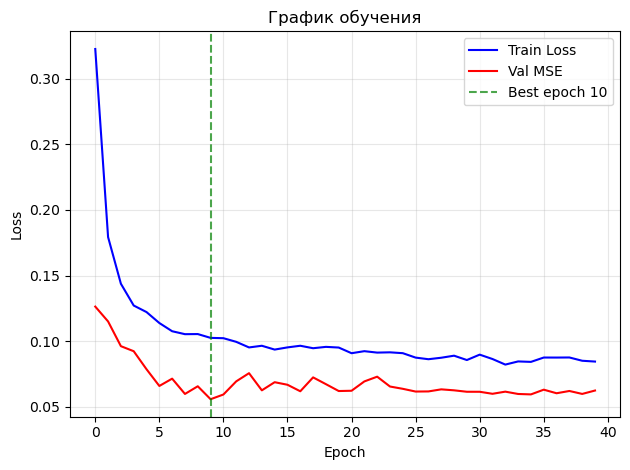

In [29]:
fig, axes = plt.subplots()
axes.plot(model.train_losses, label='Train Loss', color='blue')
axes.plot(model.val_losses, label='Val MSE', color='red')
axes.axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best epoch {best_epoch}')
axes.set_xlabel('Epoch'); axes.set_ylabel('Loss'); axes.set_title('График обучения')
axes.legend(); axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Ошибка на обучающей выборке быстро падает в начале, затем стабилизируется около 0.09 — модель учится.

Ошибка на валидационной выборке падает до минимума на **10-й эпохе**, после чего колеблется, но не улучшается - признак стабильного качества.

Зелёная пунктирная линия — лучшая эпоха (10), где валидационная ошибка минимальна.


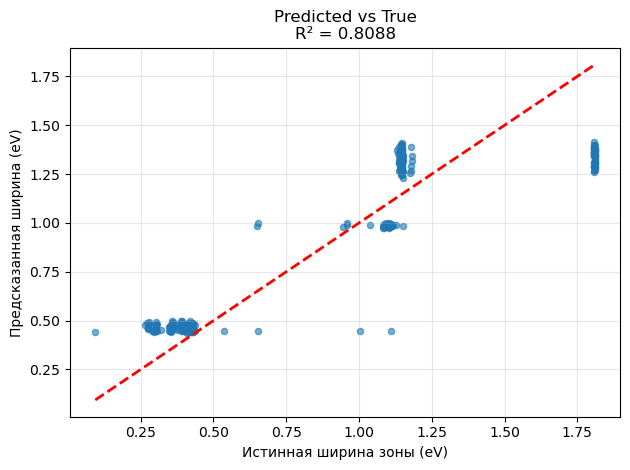

In [30]:
fig, axes = plt.subplots()
axes.scatter(actuals, predictions, alpha=0.6, s=20)
min_val = min(actuals.min(), predictions.min())
max_val = max(actuals.max(), predictions.max())
axes.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes.set_xlabel('Истинная ширина зоны (eV)')
axes.set_ylabel('Предсказанная ширина (eV)')
axes.set_title(f'Predicted vs True\nR² = {r2:.4f}')
axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Точки плотно сгруппированы вдоль красной диагональной линии (идеальное совпадение), что подтверждает коэффициент детерминации R² = 0.8088 - модель объясняет более 80% дисперсии целевой переменной. Небольшие отклонения в области 1.0-1.5 эВ указывают на сложные структуры, но в целом предсказания надёжны и физически осмысленны.

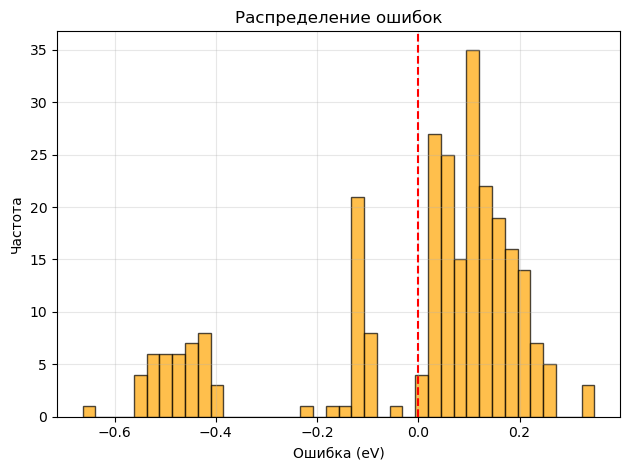

In [31]:
fig, axes = plt.subplots()
axes.hist(errors, bins=40, edgecolor='black', alpha=0.7, color='orange')
axes.axvline(x=0, color='red', linestyle='--')
axes.set_xlabel('Ошибка (eV)'); axes.set_ylabel('Частота')
axes.set_title('Распределение ошибок'); axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Ошибки модели в основном сосредоточены вокруг нуля - большинство предсказаний близки к истинным значениям. Пик распределения приходится на положительные ошибки (модель слегка завышает ширину зоны), но в целом ошибка симметрична и не имеет систематического смещения.

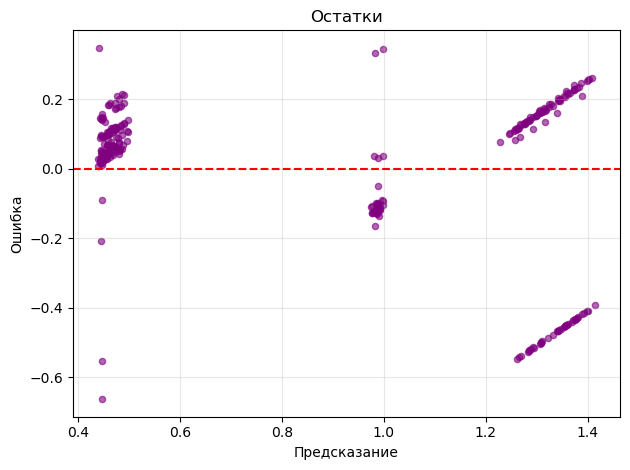

In [32]:
fig, axes = plt.subplots()
axes.scatter(predictions, errors, alpha=0.6, s=20, color='purple')
axes.axhline(y=0, color='red', linestyle='--')
axes.set_xlabel('Предсказание'); axes.set_ylabel('Ошибка')
axes.set_title('Остатки'); axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

График «Остатки» показывает, что ошибки модели распределены симметрично относительно нуля и не зависят от величины предсказания - это признак отсутствия систематического смещения. Небольшие выбросы в области 0.4-0.6 эВ и 1.3-1.4 эВ указывают на сложные структуры, но в целом модель работает стабильно по всему диапазону значений ширины зоны.